<a href="https://colab.research.google.com/github/amkobee/ADS/blob/main/ADS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import random
import urllib.request
import os
import matplotlib.pyplot as plt
import pathlib
from PIL import Image
import requests
import zipfile
import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Dataset creation
Downloading the photos from Flickr and downloading the photos as a zip. <br>
The images are being downloaded via the FlickrAPI and stored in seperate folders for each class. In order to do that the user must create a public and secret key as described on the Flickr website https://www.flickr.com/services/apps/create/apply/. Add the new values to `FLICKR_PUBLIC` and `FLICKR_SECRET`<br>
The images are stored on GitHub - due to GitHub file size limitations we were only able to store a total of 100 MB. We decided to store around 5000 images with FlickrAPI size "s". <br>
In order to run the function the variable `download_new_photos` must be set to `True`. Additional keywords/classes can be introduced as well and the amount of photos to download can be changed in the variable `TOTAL_PHOTOS`

In [2]:
# set to False to not download new photos
download_new_photos = False

# the keywords to look photos for
keywords = ['sea', 'desert', 'mountain', 'river', 'forest']

# Function to download pictures from Flickr

def download_photos():

    # install and import FlickrAPI package
    !pip install flickrapi
    from flickrapi import FlickrAPI

    # Keys for flickr API
    FLICKR_PUBLIC = '5829447acb20544b640f7c58b058614a'
    FLICKR_SECRET = '856705a9f309b147'

    # Settings (extras = different resolution of photos)
    flickr = FlickrAPI(FLICKR_PUBLIC, FLICKR_SECRET, format='parsed-json')
    extras = 'url_s'

    # how many photos per category
    TOTAL_PHOTOS = 2000
    PHOTOS_PER_PAGE = 500

    cwd = os.getcwd()
    print(f'Photos will be stored at: {cwd}')

    # create photos directory
    try:
        os.mkdir('photos')
        print('Created folder photos')
    except:
        print('Folder "photos" already exists')

    # download the photos per keyword
    for word in keywords:
        # get all photos of the category
        page = 1
        photos = flickr.photos.search(tags=word, text=word, page=page, per_page=PHOTOS_PER_PAGE, extras=extras, content_type=1)

        # create subfolders
        try:
            os.mkdir('photos/'+word)
            print('Created folder ' + word)
        except:
            print(f'Folder "{word}" already exists')

        # download the photos
        j = 1 # index for filenames - won't be reset
        filename = ''
        batch = 1
        total_batch = int(TOTAL_PHOTOS/100)

        while j <= TOTAL_PHOTOS:
            i = random.randint(1, PHOTOS_PER_PAGE-1)
            try:
                url = photos['photos']['photo'][i]['url_s']
            except:
                try:
                  error_photo = photos['photos']['photo'][i]
                  print(f'Error at {error_photo}')
                except:
                  pass

            filename = 'photo_' + str(j) + '.jpg'
            directory = 'photos/' + word + "/" + filename
            urllib.request.urlretrieve(url, directory)
            #print(f'Category {word}: Page {page}; Downloading {j} of {TOTAL_PHOTOS}')
            if j % 100 == 0:
                print(f'Batch {batch} of {total_batch} done')
                batch += 1
            j += 1

            # reached end of page - reset i and increase page
            if j % 500 == 0:
                page += 1
                print('Reached end of page')
                photos = flickr.photos.search(text=word, page=page, per_page=PHOTOS_PER_PAGE, extras=extras, content_type=1)


    print('Finished downloading the photos')
    
    # store all in zip and download
    print('Creating zip file and downloading it')
    !zip -r /content/photos/photos.zip /content/photos
    from google.colab import files
    files.download("/content/photos/photos.zip")

if download_new_photos:
    download_photos()

# Data Exploration
Retrieving the data from GitHub and retrieving example images of the dataset

In [3]:
# Download zip file from GitHub
url = 'https://github.com/amkobee/ADS/raw/main/photos.zip'
r = requests.get(url, allow_redirects=True)

open('photos.zip', 'wb').write(r.content)

# Unzip the file
with zipfile.ZipFile('photos.zip', 'r') as zip_ref:
    zip_ref.extractall()            # folder named "content" will be created

In [4]:
# get the amount of photos
data_dir = '/content/content/photos/'
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

5000


In [5]:
# create a dataset containing all information

batch_size = 32
img_height = 180
img_width = 180

full_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# get the class names from the folder names
class_names = full_ds.class_names
print(class_names)

Found 5000 files belonging to 5 classes.
['desert', 'forest', 'mountain', 'river', 'sea']


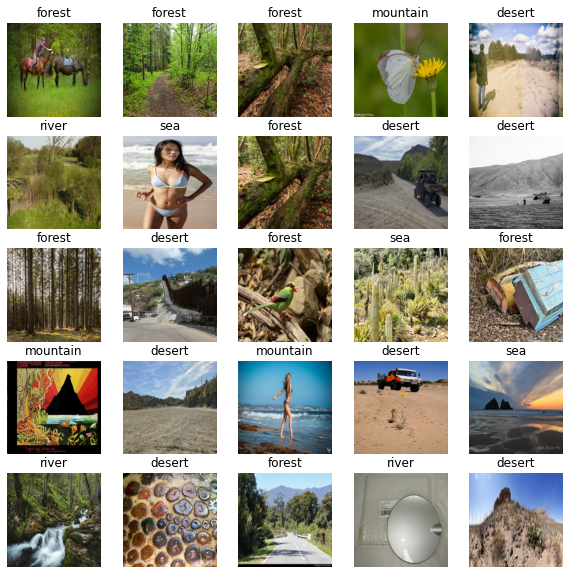

In [6]:
# print some example images
plt.figure(figsize=(10, 10))
for images, labels in full_ds.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Result Discussion

Retrieving the images from a platform where everyone can upload their on images with own tags and descriptions can lead to bad data for our model. <br>
In order to mitigate that risk we introduced randomnes to our fetching function. <br>
With that we want to avoid bad data on one handside on the other we don't want to use mulitple pictures of the same object/landscape uploaded by the same user.

# Data Preparation

In [7]:
# split in training and test set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5000 files belonging to 5 classes.
Using 4000 files for training.
Found 5000 files belonging to 5 classes.
Using 1000 files for validation.


# Model Creation and Training

Below we will show different iterations of our models <br>
The first model shows our initial setup. The following will show all the modifications that were made during the process

## First training

In [44]:
# set amount of classes to amount of keywords
num_classes = len(keywords)

# define the model
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# print summary of the model
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_8 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 22, 22, 64)      

In [45]:
# Train the model
epochs=20
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

# save the model
model.save('landscape_classifier_v1.h5')

Epoch 1/20
125/125 [==============================] - 7s 53ms/step - loss: 1.5203 - accuracy: 0.3480 - val_loss: 1.4174 - val_accuracy: 0.4130
Epoch 2/20
125/125 [==============================] - 7s 52ms/step - loss: 1.2526 - accuracy: 0.5065 - val_loss: 1.2133 - val_accuracy: 0.5260
Epoch 3/20
125/125 [==============================] - 7s 52ms/step - loss: 0.9560 - accuracy: 0.6445 - val_loss: 1.0525 - val_accuracy: 0.6260
Epoch 4/20
125/125 [==============================] - 6s 50ms/step - loss: 0.6139 - accuracy: 0.7960 - val_loss: 1.0630 - val_accuracy: 0.7020
Epoch 5/20
125/125 [==============================] - 6s 49ms/step - loss: 0.4067 - accuracy: 0.8668 - val_loss: 1.0677 - val_accuracy: 0.7170
Epoch 6/20
125/125 [==============================] - 6s 49ms/step - loss: 0.2943 - accuracy: 0.9093 - val_loss: 1.3027 - val_accuracy: 0.7150
Epoch 7/20
125/125 [==============================] - 7s 51ms/step - loss: 0.2223 - accuracy: 0.9315 - val_loss: 1.2605 - val_accuracy: 0.7410

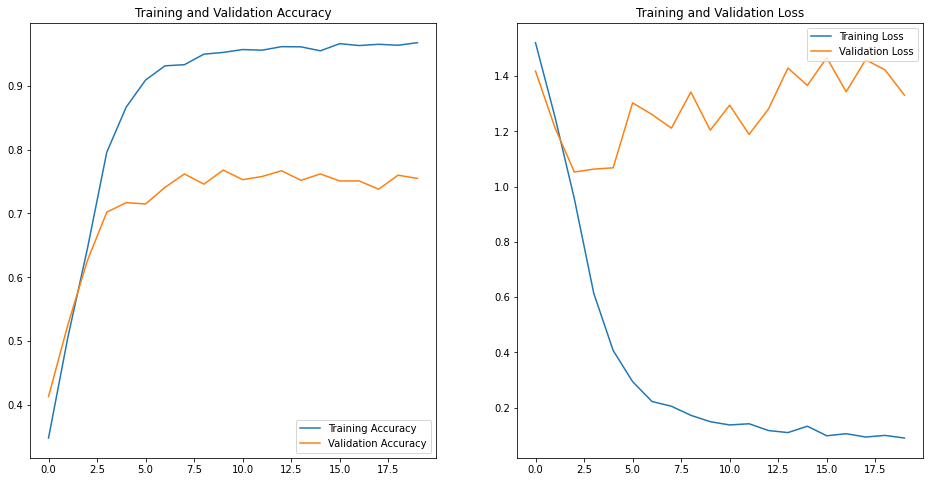

In [46]:
# Visualizing training results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### Result Discussion

We reached quite a good result on the first try with the training data set. <br>
In accuracy the model performs approx. 20-25% worse with the validation data set. Additionally the difference in loss is extremely high compared to the trainig data set <br>
In order to improve the result for the validation data set we'll introduce **dropout, regularization** and **data augmentation** to the model in the next iteration in order to avoid overfitting.

## Second training

Added dropout and regularization to the model

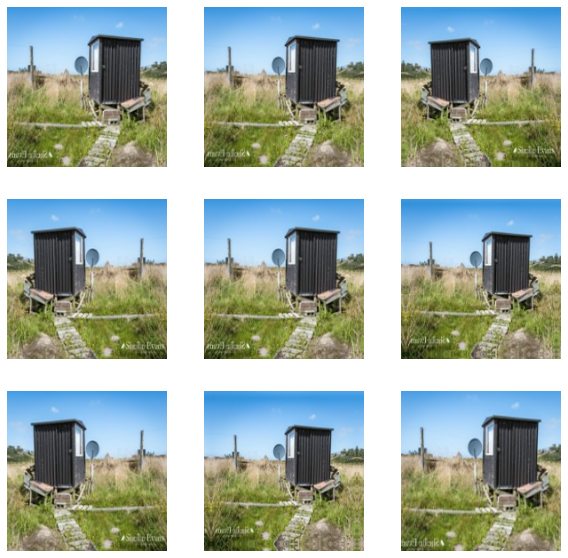

In [47]:
# data augmentation

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

# print an example
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [48]:
# define the model
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
  layers.Dense(num_classes)
])

# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# print summary of the model
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_16 (Sequential)   (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_9 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 45, 45, 64)      

In [49]:
# train the model
epochs=20
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

# save the model
model.save('landscape_classifier_v2.h5')

Epoch 1/20
125/125 [==============================] - 8s 59ms/step - loss: 1.8247 - accuracy: 0.3195 - val_loss: 1.5835 - val_accuracy: 0.3440
Epoch 2/20
125/125 [==============================] - 7s 52ms/step - loss: 1.5253 - accuracy: 0.4130 - val_loss: 1.5504 - val_accuracy: 0.3750
Epoch 3/20
125/125 [==============================] - 7s 53ms/step - loss: 1.4918 - accuracy: 0.4333 - val_loss: 1.4663 - val_accuracy: 0.4290
Epoch 4/20
125/125 [==============================] - 7s 58ms/step - loss: 1.4657 - accuracy: 0.4502 - val_loss: 1.4441 - val_accuracy: 0.4650
Epoch 5/20
125/125 [==============================] - 7s 52ms/step - loss: 1.4541 - accuracy: 0.4885 - val_loss: 1.4467 - val_accuracy: 0.4850
Epoch 6/20
125/125 [==============================] - 7s 51ms/step - loss: 1.4448 - accuracy: 0.4893 - val_loss: 1.4637 - val_accuracy: 0.4700
Epoch 7/20
125/125 [==============================] - 7s 52ms/step - loss: 1.4153 - accuracy: 0.4910 - val_loss: 1.4420 - val_accuracy: 0.4910

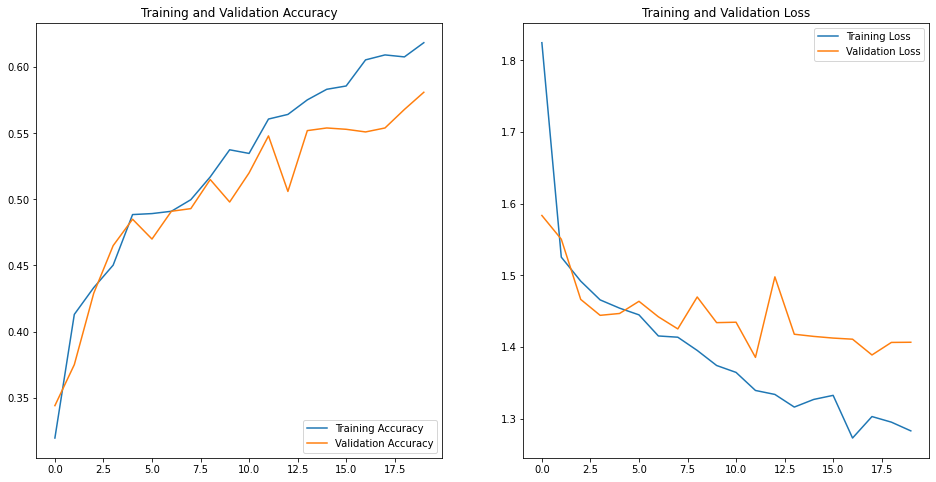

In [50]:
# Visualizing training results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### Result Discussion

We were able to reduce the overfitting by introducing dropout and data augmentation. <br>
In order to improve our model we'll introduce fine tuning to the model.

## Third training

Added Early Stopping to the model to get the best result

# Model testing

In [52]:
# Scrape images from reddit
!pip install selenium
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support import expected_conditions as EC
import urllib.request

chrome_options = Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument("user-agent=Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36")
driver = webdriver.Chrome(options=chrome_options)
#wait = WebDriverWait(driver, 10)

driver.get('https://reddit.com/r/earthporn/')

i = 1
while i <= 5:
    img = driver.find_element_by_xpath(f"(//img[@alt='Post image'])[{i}]")
    src = img.get_attribute('src')

    # download the image
    urllib.request.urlretrieve(src, f"test_{i}.png")

    i += 1

driver.close()


     |████████████████████████████████| 911kB 8.2MB/s 


WebDriverException: ignored

In [56]:
!pip install selenium
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument("user-agent=Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36")
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
wd = webdriver.Chrome('chromedriver',options=options)
wd.get("https://www.google.com")

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graphics-drivers/ppa/ubu

WebDriverException: ignored

In [ ]:
# classify the images with the model



## Image Classification Error Analysis (Grad-CAM)